In [30]:
import os
os.chdir('..')

import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 设置全局字体为 SimHei (黑体) 或其他中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或 ['Microsoft YaHei'] 微软雅黑 等
plt.rcParams['axes.unicode_minus'] = False   # 解决负号 '-' 显示为方块的问题

In [2]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

In [3]:
sma_decomp = series_decomp(kernel_size=25)

In [4]:
from data_provider.data_loader import Dataset_ETT_hour
from torch.utils.data import DataLoader

dataset = Dataset_ETT_hour(
    root_path='./dataset/ETT-small/',
    data_path='ETTh1.csv',
    flag='train',
    size=[96, 48, 96],
    features='M',
    target='OT',
    timeenc=1,
    freq='h',
    scale=False
)

dataloader = DataLoader(
    dataset=dataset,
    batch_size=32,
    shuffle=False,
    num_workers=10,
    drop_last=True
)

In [5]:
batch_x, batch_y, batch_x_mark, batch_y_mark = next(iter(dataloader))

batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape

(torch.Size([32, 96, 7]),
 torch.Size([32, 144, 7]),
 torch.Size([32, 96, 4]),
 torch.Size([32, 144, 4]))

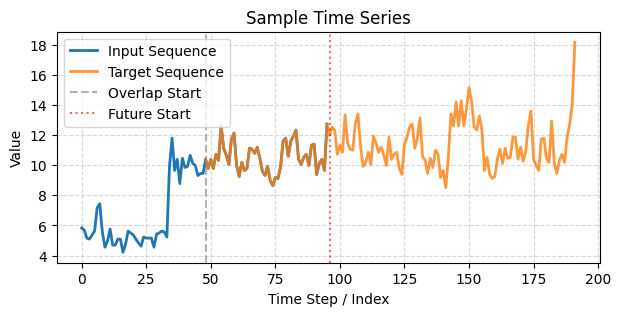

In [6]:
from utils.plotters import plot_series

plot_series(batch_x[0,:,0].numpy(), batch_y[0,:,0].numpy(), label_len=48, label_x='Input Sequence', label_y='Target Sequence', title='Sample Time Series')

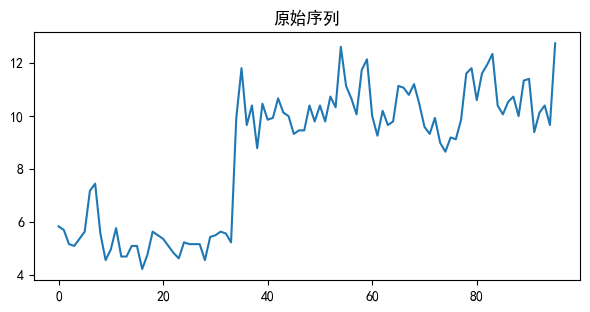

In [31]:
plt.figure(figsize=(6, 3))
plt.plot(batch_x[0, :, 0].numpy(), label='原始序列')
# plt.legend()
# plt.grid()
plt.tight_layout()
plt.title('原始序列')
plt.show()

In [32]:
from layers.ema import Decomp

decomp = Decomp(alpha=0.1)

season, trend = decomp(batch_x)

trend.shape, season.shape

(torch.Size([32, 96, 7]), torch.Size([32, 96, 7]))

In [26]:
from layers.ema import Decomp

decomp = Decomp(alpha=0.3)

season, trend = decomp(batch_x)

trend.shape, season.shape

(torch.Size([32, 96, 7]), torch.Size([32, 96, 7]))

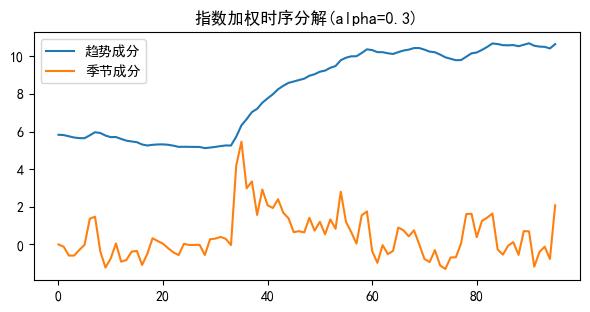

In [35]:
plt.figure(figsize=(6, 3))
# plt.plot(batch_x[0, :, 0].numpy(), label='Original Series')
plt.plot(trend[0, :, 0].numpy(), label='趋势成分')
plt.plot(season[0, :, 0].numpy(), label='季节成分')
plt.legend()
# plt.grid()
plt.tight_layout()
plt.title('指数加权时序分解(alpha=0.3)')
plt.show()

In [11]:
sma_decomp = series_decomp(kernel_size=25)

sma_season, sma_trend = sma_decomp(batch_x)

sma_season.shape, sma_trend.shape

(torch.Size([32, 96, 7]), torch.Size([32, 96, 7]))

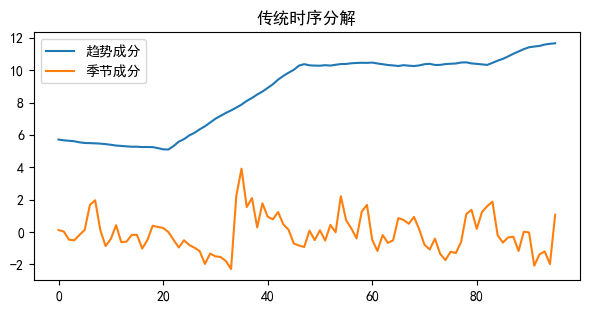

In [36]:
plt.figure(figsize=(6, 3))
# plt.plot(batch_x[0, :, 0].numpy(), label='Original Series')
plt.plot(sma_trend[0, :, 0].numpy(), label='趋势成分')
plt.plot(sma_season[0, :, 0].numpy(), label='季节成分')
plt.legend()
# plt.grid()
plt.tight_layout()
plt.title('传统时序分解')
plt.show()